<a href="https://colab.research.google.com/github/sdw1621/tensorflow_hangi_uni/blob/main/Convolutional_GAN_fashion_mnist%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Fashion MNIST Datset 불러오기

(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
all_data = np.concatenate([x_train, x_test], axis=0)
all_data = np.expand_dims(all_data, -1).astype("float32") / 255


4431872/4422102 [==============================] - 0s 0us/step


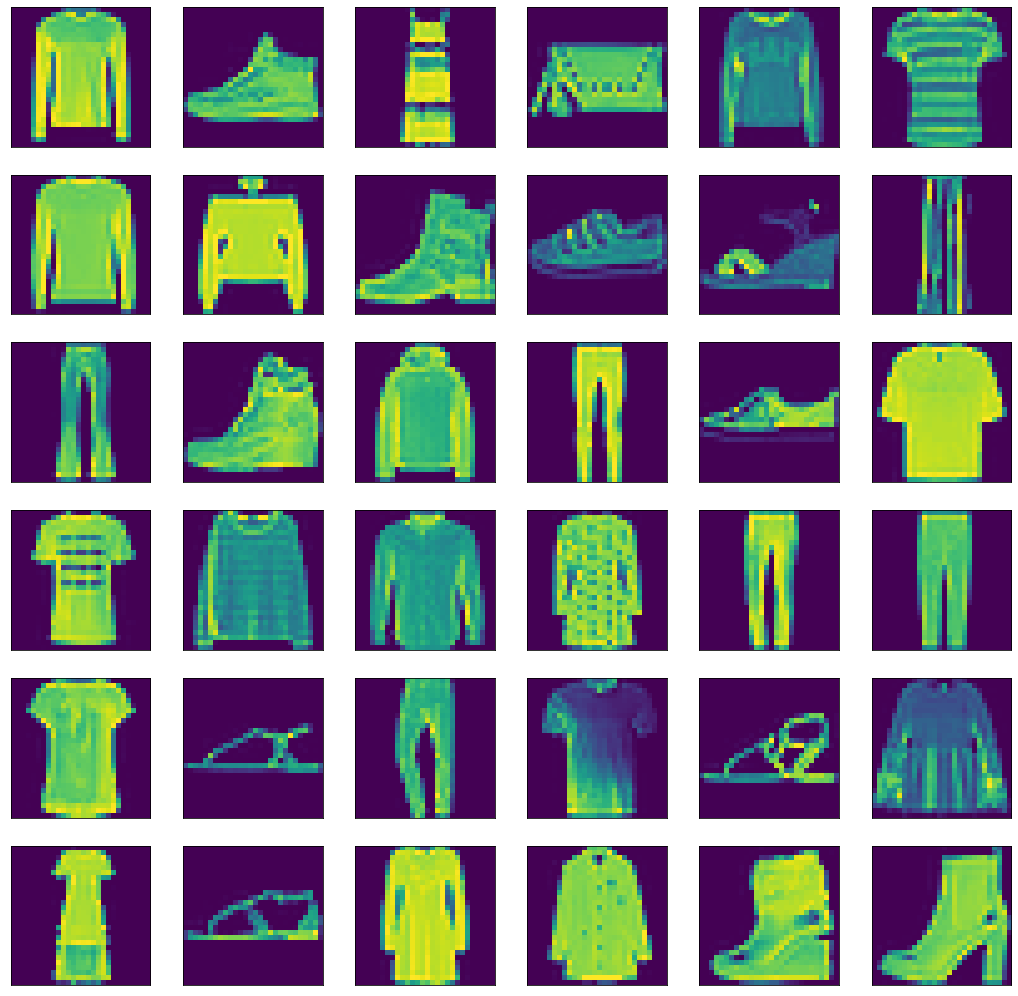

In [ ]:
# FASHION MINST 보기
import numpy as np
import matplotlib.pyplot as plt

# plot 18" x 18" 
fig = plt.figure(figsize=(18, 18))
for idx in range(36):
    id = np.random.randint(60000)
    number = fig.add_subplot(6, 6, idx+1, xticks=[], yticks=[])
    number.imshow(np.squeeze(all_data[id]))#, cmap='gray')

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1024),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1024)              6423552   
                                                                 
 dropout (Dropout)           (None, 1024)            

In [ ]:
latent_dim = 10

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 128),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              68992     
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 256)       0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
epochs = 10  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(all_data, epochs=epochs, batch_size=128)

Epoch 1/10
547/547 [==============================] - 80s 143ms/step - d_loss: 0.4702 - g_loss: 1.7376
Epoch 2/10
547/547 [==============================] - 77s 142ms/step - d_loss: 0.4585 - g_loss: 1.7522
Epoch 3/10
547/547 [==============================] - 77s 141ms/step - d_loss: 0.4593 - g_loss: 1.7274
Epoch 4/10
547/547 [==============================] - 77s 142ms/step - d_loss: 0.4704 - g_loss: 1.6402
Epoch 5/10
547/547 [==============================] - 78s 142ms/step - d_loss: 0.4964 - g_loss: 1.5454
Epoch 6/10
547/547 [==============================] - 78s 142ms/step - d_loss: 0.4633 - g_loss: 1.7513
Epoch 7/10
547/547 [==============================] - 78s 142ms/step - d_loss: 0.4924 - g_loss: 1.5681
Epoch 8/10
547/547 [==============================] - 78s 143ms/step - d_loss: 0.4962 - g_loss: 1.5801
Epoch 9/10
547/547 [==============================] - 78s 143ms/step - d_loss: 0.4975 - g_loss: 1.5064
Epoch 10/10
547/547 [==============================] - 78s 143ms/step - d

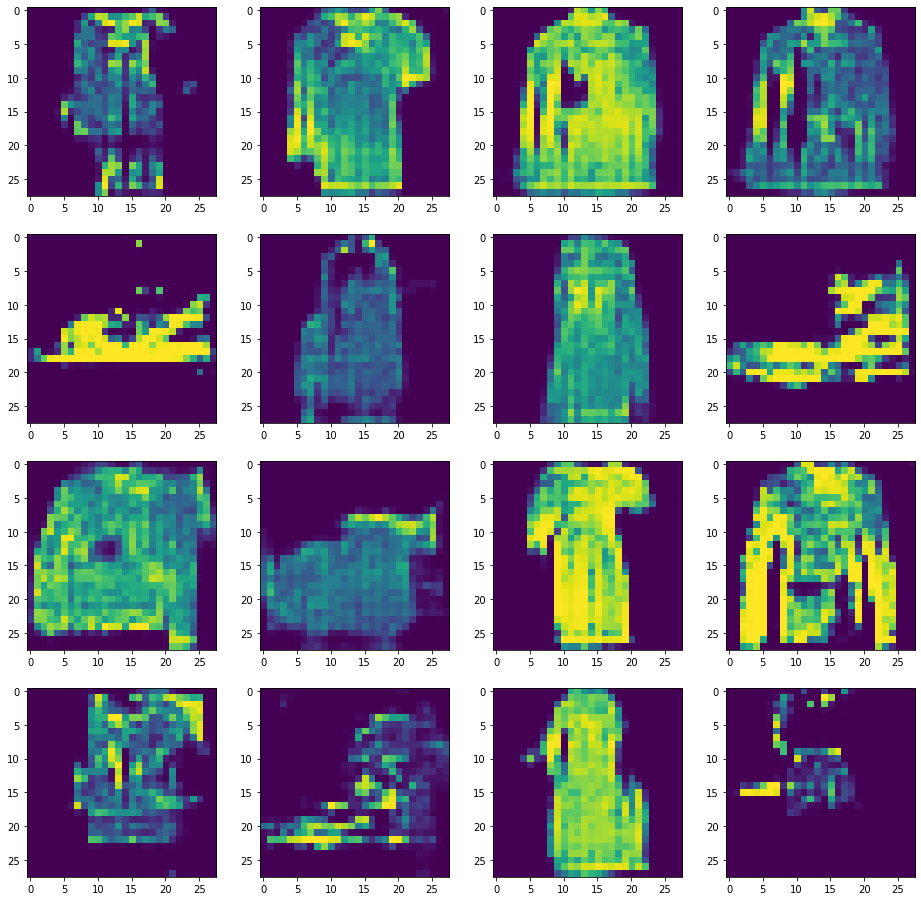

In [ ]:
# 임의의 latent 값으로 생성해보기

fig = plt.figure(figsize=(16, 16))
for idx in np.arange(16):
    latent = np.random.randn(1,10)
    image = gan.generator.predict(latent)
    sub_plot = fig.add_subplot(4,4, idx+1)
    sub_plot.imshow(np.squeeze(image)) #, cmap='gray')

